<a href="https://colab.research.google.com/github/kbharath21/iiith/blob/main/AIML_Project_Module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data

## Project
---



In [1]:
from google.colab import files

In [2]:
uploaded = files.upload()
loc_ = list(uploaded.keys())[0]
!unzip -q {loc_}

Saving Module2_ProjectFiles.zip to Module2_ProjectFiles.zip


In [3]:
!pip3 -q install biopython

import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm.autonotebook import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.1 MB/s eta 0:00:00


<ipython-input-3-5e1163c00ce1>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
data = pd.read_csv("INDIA_685.csv")
data.tail()

,StrainID,Accession_ID,Location,State,Host,Gender,Patient age,Patient status,Collection_date,Originating lab,Authors,Nuc_muts
680,hCoV-19/India/nimh-2873/2020|EPI_ISL_436137|20...,EPI_ISL_436137,Asia / India / Karnataka,Karnataka,Human,Female,28,Asymptomatic,2020-04-21,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C1281T', 'C4158T', 'G11083T', 'C13730T', 'C2..."
681,hCoV-19/India/nimh-3952/2020|EPI_ISL_436138|20...,EPI_ISL_436138,Asia / India / Karnataka,Karnataka,Human,Male,38,Asymptomatic,2020-04-23,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."
682,hCoV-19/India/nimh-3970/2020|EPI_ISL_436139|20...,EPI_ISL_436139,Asia / India / Karnataka,Karnataka,Human,Male,20,Symptomatic,2020-04-23,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."
683,hCoV-19/India/nimh-4376/2020|EPI_ISL_436140|20...,EPI_ISL_436140,Asia / India / Karnataka,Karnataka,Human,Female,52,Asymptomatic,2020-04-24,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."
684,hCoV-19/India/nimh-4378/2020|EPI_ISL_436141|20...,EPI_ISL_436141,Asia / India / Karnataka,Karnataka,Human,Female,27,Asymptomatic,2020-04-24,District Surveillance Unit,"Chitra Pattabiraman, Vijayalakshmi Reddy, Hars...","['C241T', 'C3037T', 'C3634T', 'A3742G', 'C1440..."


In [5]:
fasta_sequences = SeqIO.parse(open("sequences.fasta"),'fasta')

counter = 0
for fasta in fasta_sequences:
    counter +=1

print("Number of sequences is:", counter)

Number of sequences is: 685


In [6]:
def calc_score(examplesequence):

    position = 0
    score = 0
    value = 0
    flag = 0

    for base in examplesequence:

        if(base == "A" or base == "a"):
            value = 0
        elif(base == "G" or base == "g"):
            value = 1
        elif(base == "T" or base == "t"):
            value = 2
        elif(base == "C" or base == "c"):
            value = 3
        else:
            flag=1

        score += (4 ** position)* value
        position+=1

    return (flag,score)

calc_score("ATAGTAG")

(0, 4680)

In [7]:
k=7
big_matrix = []
sequences_name = []

fasta_sequences = SeqIO.parse(open("sequences.fasta"),'fasta')

for fasta in tqdm(fasta_sequences):

    embedding = np.zeros(4**k, dtype=int)
    sequence = str(fasta.seq)
    sequence_name = fasta.id
    sequences_name.append(sequence_name)

    for j in range(len(sequence)-k+1):
        kmer = sequence[j:j+k]
        flag,score = calc_score(kmer)
        if(flag!=1):
            embedding[score]+=1

    embedding = embedding.tolist()
    big_matrix.append(embedding)

0it [00:00, ?it/s]

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(big_matrix)
pca_data = pca.transform(big_matrix)

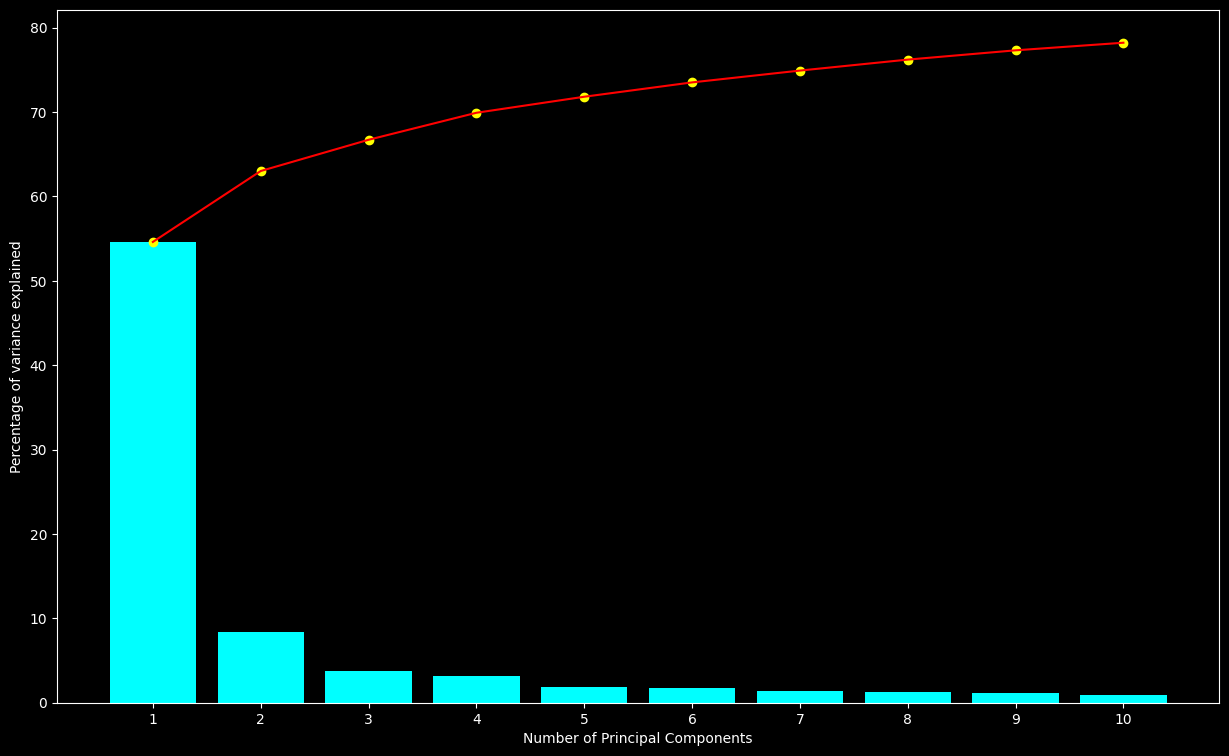

In [9]:
import matplotlib.pyplot as plt

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels_all = ['PC'+str(x) for x in range(1, len(per_var)+1)]
per_var=per_var[:10]
labels = [str(x) for x in range(1, len(per_var)+1)]

with plt.style.context('dark_background'):
    plt.figure(figsize = (15, 9))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels, color = "aqua")
    plt.plot(range(1,len(per_var)+1), np.cumsum(per_var), color = "red")
    plt.scatter(range(1,len(per_var)+1), np.cumsum(per_var), color = "yellow")

In [10]:
final_df = pd.DataFrame(columns=["StrainID", "PC1", "PC2", "PC3", "State"])
pca_df = pd.DataFrame(pca_data, index=[*sequences_name], columns = labels_all)

for sample in pca_df.index:

    dicti = dict()

    dicti["StrainID"] = sample
    dicti["PC1"] = pca_df.PC1.loc[sample]
    dicti["PC2"] = pca_df.PC2.loc[sample]
    dicti["PC3"] = pca_df.PC3.loc[sample]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]

    final_df = pd.concat([final_df, pd.DataFrame([dicti])], ignore_index=True)

final_df.head()

,StrainID,PC1,PC2,PC3,State
0,hCoV-19/India/763/2020|EPI_ISL_420543|2020-03-03,-4.326235,-3.484139,-1.786329,Stateless
1,hCoV-19/India/770/2020|EPI_ISL_420545|2020-03-03,-4.234399,-3.509996,-1.804263,Stateless
2,hCoV-19/India/772/2020|EPI_ISL_420547|2020-03-03,-4.184090,-3.754896,-1.696688,Stateless
3,hCoV-19/India/773/2020|EPI_ISL_420549|2020-03-03,-4.194559,-3.531680,-1.895380,Stateless
4,hCoV-19/India/777/2020|EPI_ISL_420551|2020-03-03,-4.186462,-3.550434,-1.888697,Stateless


In [11]:
import plotly.graph_objs as go
import plotly.express as px

In [12]:
for_x = final_df.PC1.tolist()
for_y = final_df.PC2.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, title="Principal Component Axis",
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"
                })

fig.show(renderer = "colab")

In [13]:
from sklearn.manifold import TSNE
random_state = 0
n_components = 2
perplexity = 30
n_iter = 10000
model = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, n_iter=n_iter)
tsne_data = model.fit_transform(np.array(big_matrix))


In [14]:
final_df = pd.DataFrame(columns=["StrainID", "X", "Y", "State"])
pca_df = pd.DataFrame(pca_data, index=[*sequences_name], columns = labels_all)

i = 0
for sample in pca_df.index:

    dicti = dict()

    dicti["StrainID"] = sample
    dicti["X"] = tsne_data[i][0]
    dicti["Y"] = tsne_data[i][1]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]

    final_df = pd.concat([final_df, pd.DataFrame([dicti])], ignore_index=True)
    i+=1

final_df.tail()

,StrainID,X,Y,State
680,hCoV-19/India/MaxCov0046_CSIR-IGIB/2020|EPI_IS...,-1.670846,12.345421,Delhi
681,hCoV-19/India/MaxCov0047_CSIR-IGIB/2020|EPI_IS...,-1.516235,12.777357,Delhi
682,hCoV-19/India/MaxCov0048_CSIR-IGIB/2020|EPI_IS...,-1.303149,13.702475,Delhi
683,hCoV-19/India/MaxCov0049_CSIR-IGIB/2020|EPI_IS...,-0.786874,14.016081,Delhi
684,hCoV-19/India/MaxCov0050_CSIR-IGIB/2020|EPI_IS...,-2.246538,12.155030,Delhi


In [15]:
for_x = final_df.X.tolist()
for_y = final_df.Y.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, title="t-SNE", height=600, width=1000,
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"})

fig.show(renderer = 'colab')

In [16]:
mutations = []
for i in range(len(data)):

    sample_muts = data["Nuc_muts"][i][1:][:-1].split(",")

    for j in sample_muts:
        mut = j.strip()[1:][:-1]
        if(len(mut)>=2):
            if(mut not in mutations):
                mutations.append(mut)

print(len(mutations))

1279


In [17]:
samplelist = data["StrainID"].tolist()
df = pd.DataFrame(columns = [*samplelist])
df = df.replace(np.nan,0)

for mutation in mutations:

    dicti = dict(zip(samplelist, np.zeros(len(samplelist), dtype=int)))

    for i in range(len(data)):
        flag=0
        strainid = data["StrainID"][i]
        sample_muts = data["Nuc_muts"][i][1:][:-1].split(",")

        for j in sample_muts:
            mut = j.strip()[1:][:-1]
            if(len(mut)>=2):
                if(mut == mutation):
                    flag = 1
                    break

        dicti[strainid]=flag

    df = pd.concat([df, pd.DataFrame([dicti])], ignore_index=True)

df = df.T

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278
hCoV-19/India/nimh-2873/2020|EPI_ISL_436137|2020-04-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
hCoV-19/India/nimh-3952/2020|EPI_ISL_436138|2020-04-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
hCoV-19/India/nimh-3970/2020|EPI_ISL_436139|2020-04-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
hCoV-19/India/nimh-4376/2020|EPI_ISL_436140|2020-04-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
hCoV-19/India/nimh-4378/2020|EPI_ISL_436141|2020-04-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [18]:
pca = PCA()
pca.fit(df)
pca_data = pca.transform(df)

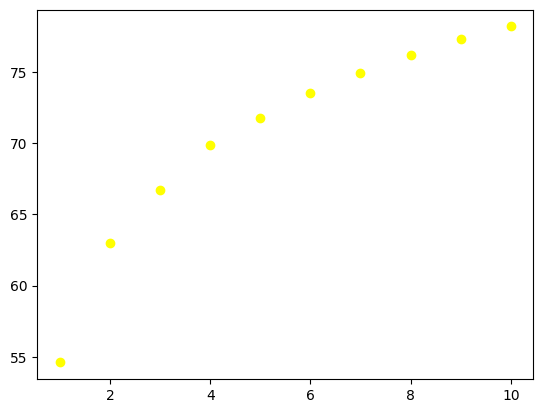

In [19]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels_all = ['PC'+str(x) for x in range(1, len(per_var)+1)]
per_var=per_var[:10]
labels = [str(x) for x in range(1, len(per_var)+1)]

with plt.style.context('dark_background'):
    plt.figure(figsize = (15, 9))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels, color = "aqua")
    plt.plot(range(1,len(per_var)+1), np.cumsum(per_var), color = "red")
    plt.scatter(range(1,len(per_var)+1), np.cumsum(per_var), color = "yellow")

In [20]:
final_df = pd.DataFrame(columns=["StrainID", "PC1", "PC2", "State"])
pca_df = pd.DataFrame(pca_data, index=[*samplelist], columns = labels_all)

for sample in pca_df.index:

    dicti = dict()

    dicti["StrainID"] = sample
    dicti["PC1"] = pca_df.PC1.loc[sample]
    dicti["PC2"] = pca_df.PC2.loc[sample]
    dicti["State"] = data[data["StrainID"]==sample]["State"].tolist()[0]

    final_df = pd.concat([final_df, pd.DataFrame([dicti])], ignore_index=True)

final_df.tail()

,StrainID,PC1,PC2,State
680,hCoV-19/India/nimh-2873/2020|EPI_ISL_436137|20...,1.530221,0.079550,Karnataka
681,hCoV-19/India/nimh-3952/2020|EPI_ISL_436138|20...,-1.063943,-0.405022,Karnataka
682,hCoV-19/India/nimh-3970/2020|EPI_ISL_436139|20...,-1.058232,-0.410670,Karnataka
683,hCoV-19/India/nimh-4376/2020|EPI_ISL_436140|20...,-1.057465,-0.409620,Karnataka
684,hCoV-19/India/nimh-4378/2020|EPI_ISL_436141|20...,-1.057465,-0.409620,Karnataka


In [49]:
for_x = final_df.PC1.tolist()
for_y = final_df.PC2.tolist()
for_states = final_df.State.tolist()
for_hover = final_df.StrainID.tolist()

fig = px.scatter(x=for_x, y=for_y, color=for_states, height=600, width=1200,
                 title="Principal Component Axis",
                color_discrete_map={
                "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"})
fig.show(renderer = 'colab')

t-SNE

In [39]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
random_state=0
perplexity=30

In [50]:
tsne_model=TSNE(n_components=2,random_state=random_state,perplexity=perplexity,n_iter=10000)
tsne_data=tsne_model.fit_transform(np.array(big_matrix))
neighbours=5

for_x_tsne=tsne_data[:,0]
for_y_tsne=tsne_data[:,1]
fig_tsne=px.scatter(x=for_x_tsne,y=for_y_tsne,color=for_states,title="t-sne",color_discrete_map={
  "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"
})
fig_tsne.show()

ISOMAP

In [48]:
#isomap

isomap_model=Isomap(n_neighbors=neighbors,n_components=2)
isomap_data=isomap_model.fit_transform(np.array(big_matrix))

for_x_isomap=isomap_data[:,0]
for_y_isomap=isomap_data[:,1]
fig_isomap=px.scatter(x=for_x_isomap,y=for_y_isomap,color=for_states,title="ISOMAP",color_discrete_map={
  "Stateless": "grey",
                "Tamil Nadu": "green",
                "Telangana": "red",
                "Maharashtra": "orange",
                "Gujarat": "magenta",
                "Delhi": "purple",
                "West Bengal": "aqua",
                "Haryana": "pink",
                "Odisha": "blue",
                "Madhya Pradesh": "brown",
                "Karnataka": "black"
})
fig_isomap.show()